<a href="https://colab.research.google.com/github/carlosvalenciano/Project4/blob/main/Stock_Market_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yahoo_fin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 11.7 MB/s eta 0:00:00
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1256 sha256=a833c577c3c375734bf5dd7d15d3cdd40e24b8a920bf3630eb152f797956ea78
  Stored in directory: /root/.cache/pip/wheels/25/42/45/b773edc52acb16cd2db4cf1a0b47117e2f69bb4eb300ed0e70
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6048 sha256=db9e5a563d655b905506682317068d366cb8a6bf9a2a5375ddea8670ed1dd20c
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built bs4 sgmllib3k
  Attempting uninstall: urllib3
    Found exist

In [2]:
import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf
import pandas as pd

# Data preparation
from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque

#import yfinance as yf
#from pandas_datareader import data as pdr
#yf.pdr_override()

# AI
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# For time stamps
from datetime import datetime

# Graphics library
import matplotlib.pyplot as plt

In [3]:
# SETTINGS

# Window size or the sequence length, 7 (1 week)
N_STEPS = 7

# Lookup steps, 1 is the next day, 3 = day after tomorrow
LOOKUP_STEPS = [1, 2, 3]

# The tech stocks we'll use for this analysis
STOCK = input('Enter a ticker. ')
print(f'You entered {STOCK}.')

# Current date
date_now = tm.strftime('%Y-%m-%d')
date_3_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

Enter a ticker. GOOG
You entered GOOG.


In [4]:
# LOAD DATA
# from yahoo_fin
# for 1104 bars with interval = 1d (one day)
init_df = yf.get_data(
    STOCK,
    start_date=date_3_years_back,
    end_date=date_now,
    interval='1d')

In [5]:
# create the column 'date' based on index column
init_df['Date'] = init_df.index

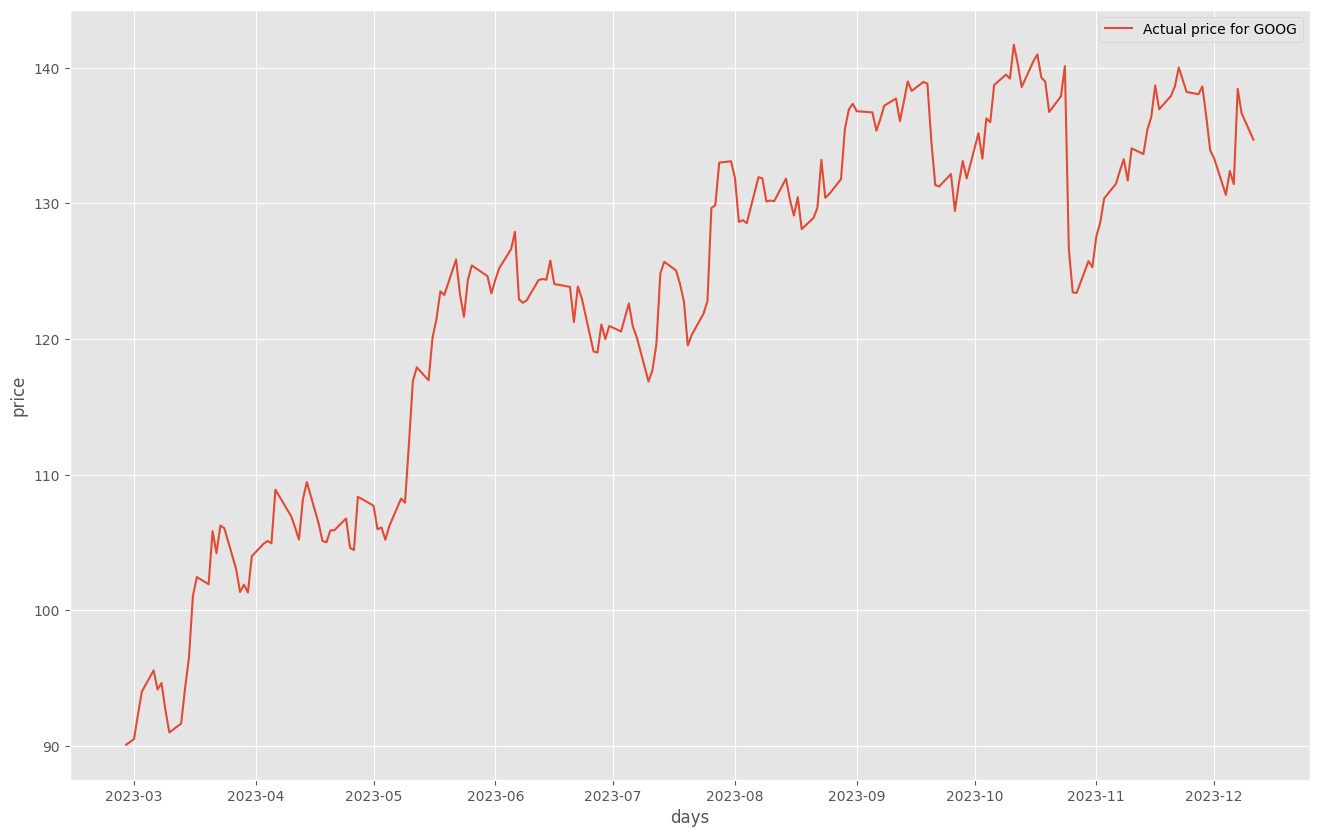

In [6]:
# Let's preliminary see our data on the graphic
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(init_df['close'][-200:])
plt.xlabel("days")
plt.ylabel("price")
plt.legend([f'Actual price for {STOCK}'])
plt.show()

In [7]:
# Scale data for ML engine
scaler = MinMaxScaler()
init_df['scaled_close'] = scaler.fit_transform(np.expand_dims(init_df['close'].values, axis=1))
display(init_df)

,open,high,low,close,adjclose,volume,ticker,Date,scaled_close
2020-12-03,91.200500,92.360001,91.132500,91.338501,91.338501,24546000,GOOG,2020-12-03,0.116760
2020-12-04,91.225998,91.657997,90.849503,91.399498,91.399498,27564000,GOOG,2020-12-04,0.117668
2020-12-07,90.949997,91.618500,90.289001,90.973999,90.973999,26418000,GOOG,2020-12-07,0.111338
2020-12-08,90.504997,91.095001,89.810249,90.927498,90.927498,21926000,GOOG,2020-12-08,0.110646
2020-12-09,90.600502,91.713501,88.390503,89.206497,89.206497,30152000,GOOG,2020-12-09,0.085043
...,...,...,...,...,...,...,...,...,...
2023-12-05,130.369995,133.539993,129.729996,132.389999,132.389999,19235100,GOOG,2023-12-05,0.727473
2023-12-06,132.899994,133.309998,131.309998,131.429993,131.429993,16360600,GOOG,2023-12-06,0.713191
2023-12-07,136.600006,140.000000,136.229996,138.449997,138.449997,38419400,GOOG,2023-12-07,0.817626
2023-12-08,135.660004,137.990005,135.570007,136.639999,136.639999,22990900,GOOG,2023-12-08,0.790699


In [8]:
# create the column 'date' based on index column
init_df['date'] = init_df.index

In [9]:
def PrepareData(days):
  df = init_df.copy()
  df['future'] = df['scaled_close'].shift(-days)
  last_sequence = np.array(df[['scaled_close']].tail(days))
  df.dropna(inplace=True)
  sequence_data = []
  sequences = deque(maxlen=N_STEPS)

  for entry, target in zip(df[['scaled_close'] + ['Date']].values, df['future'].values):
      sequences.append(entry)
      if len(sequences) == N_STEPS:
          sequence_data.append([np.array(sequences), target])

  last_sequence = list([s[:len(['scaled_close'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)

  # construct the X's and Y's
  X, Y = [], []
  for seq, target in sequence_data:
      X.append(seq)
      Y.append(target)

  # convert to numpy arrays
  X = np.array(X)
  Y = np.array(Y)

  return df, last_sequence, X, Y

In [10]:
def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['scaled_close']))))
  model.add(Dropout(0.3))
  model.add(LSTM(120, return_sequences=False))
  model.add(Dropout(0.3))
  model.add(Dense(20))
  model.add(Dense(1))

  BATCH_SIZE = 128
  EPOCHS = 50

  model.compile(loss='mean_squared_error', optimizer='adam')

  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

  model.summary()

  return model

In [11]:
# GET PREDICTIONS
predictions = []

for step in LOOKUP_STEPS:
  df, last_sequence, x_train, y_train = PrepareData(step)
  x_train = x_train[:, :, :len(['scaled_close'])].astype(np.float32)

  model = GetTrainedModel(x_train, y_train)

  last_sequence = last_sequence[-N_STEPS:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(last_sequence)
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  predictions.append(round(float(predicted_price), 2))

Epoch 1/50
6/6 [==============================] - 6s 65ms/step - loss: 0.2115
Epoch 2/50
6/6 [==============================] - 0s 65ms/step - loss: 0.0400
Epoch 3/50
6/6 [==============================] - 0s 60ms/step - loss: 0.0224
Epoch 4/50
6/6 [==============================] - 0s 64ms/step - loss: 0.0232
Epoch 5/50
6/6 [==============================] - 0s 66ms/step - loss: 0.0128
Epoch 6/50
6/6 [==============================] - 0s 40ms/step - loss: 0.0138
Epoch 7/50
6/6 [==============================] - 0s 37ms/step - loss: 0.0090
Epoch 8/50
6/6 [==============================] - 0s 33ms/step - loss: 0.0092
Epoch 9/50
6/6 [==============================] - 0s 36ms/step - loss: 0.0076
Epoch 10/50
6/6 [==============================] - 0s 37ms/step - loss: 0.0069
Epoch 11/50
6/6 [==============================] - 0s 34ms/step - loss: 0.0070
Epoch 12/50
6/6 [==============================] - 0s 35ms/step - loss: 0.0068
Epoch 13/50
6/6 [==============================] - 0s 33ms/st

In [12]:
# Execute model for the whole history range
copy_df = init_df.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_df[f'predicted_close'] = y_predicted_transformed

# Add predicted results to the table
date_now = dt.date.today()
date_tomorrow = dt.date.today() + dt.timedelta(days=1)
date_after_tomorrow = dt.date.today() + dt.timedelta(days=2)

date_now = [predictions[0], f'{date_now}', 0, 0]
date_tomorrow = [predictions[1], f'{date_tomorrow}', 0, 0]
date_after_tomorrow = [predictions[2], f'{date_after_tomorrow}', 0, 0]

24/24 [==============================] - 0s 10ms/step


In [19]:
# Make a prediction using the testing data
testing_predictions = model.predict(X)

NameError: ignored

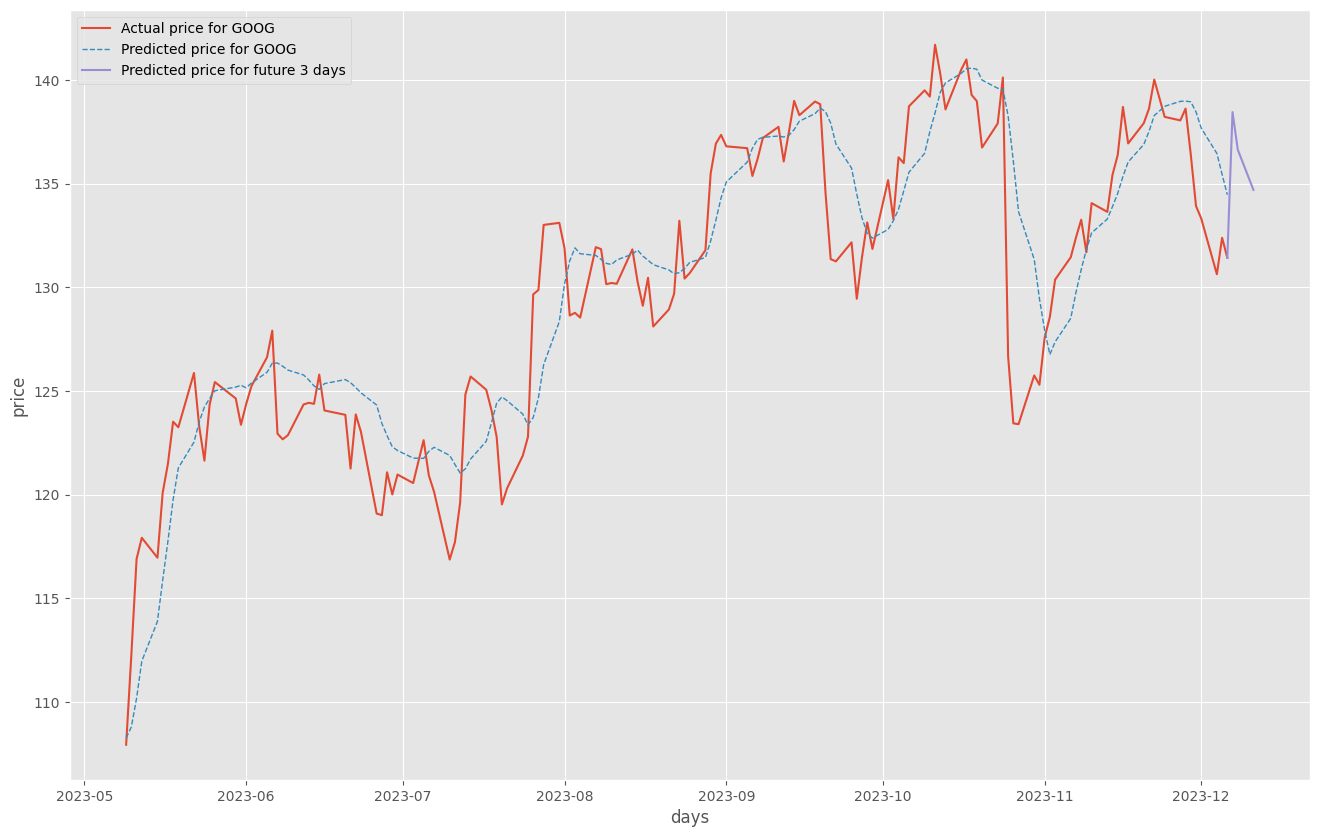

In [13]:
# Result chart
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(copy_df['close'][-150:].head(147))
plt.plot(copy_df['predicted_close'][-150:].head(147), linewidth=1, linestyle='dashed')
plt.plot(copy_df['close'][-150:].tail(4))
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}',
            f'Predicted price for {STOCK}',
            f'Predicted price for future 3 days'])
plt.show()

In [14]:
if bool(predictions) == True and len(predictions) > 0:
  predictions_list = ['$' + str(d) for d in predictions]
  predictions_str = ', '.join(predictions_list)
  message = f'{STOCK} prediction for upcoming 3 days ({predictions_str})'

  print(message)

GOOG prediction for upcoming 3 days ($134.18, $134.83, $134.76)
